## Habitat Suitability

#### Overview

#### Data Description


#### Data Citation


#### Methods


#### Analysis

Import Libraries

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
from urllib.request import urlretrieve

import pandas as pd
import geopandas as gpd
import rioxarray as rxr

# interactive plots of vector data
import hvplot.pandas

Load Data

In [22]:
# Define downloads directory
downloads_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Downloads'
)

# Create project data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'data'
)

# Define the directory name for USFS data
grassland_units_dir = os.path.join(data_dir, 'usfs-national-grasslands')

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

In [23]:
# Only download once
usfs_pattern = os.path.join(grassland_units_dir, '*.shp')

if not glob(usfs_pattern):
    usfs_zip = f'{downloads_dir}/S_USA.NationalGrassland.zip'

    # Unzip data
    with zipfile.ZipFile(usfs_zip, 'r') as zip:
        zip.extractall(path=grassland_units_dir)

# Find the extracted .shp file path
usfs_path = glob(usfs_pattern)[0]

# Load USFS grasslands units from shapefile
usfs_grasslands_gdf = (
    gpd.read_file(usfs_path)
)

usfs_grasslands_gdf.head()

,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
0,281771010328,Fort Pierre National Grassland,209044.225,0.095149,1.455518,"POLYGON ((-100.08409 44.28162, -100.08409 44.2..."
1,295507010328,Butte Valley National Grassland,19489.170,0.008557,0.853736,"MULTIPOLYGON (((-121.996 41.84049, -121.996 41..."
2,295508010328,Kiowa National Grassland,144281.321,0.058543,9.858642,"MULTIPOLYGON (((-104.30414 36.08063, -104.3041..."
3,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31081 46.51457, -97.30559 ..."
4,295510010328,Cedar River National Grassland,6717.517,0.003157,0.999947,"MULTIPOLYGON (((-101.82221 45.95896, -101.8170..."


In [20]:
# California: Butte Valley National Grassland
ca_grassland_gdf = usfs_grasslands_gdf.loc[usfs_grasslands_gdf['GRASSLANDN'] == 'Butte Valley National Grassland']

# plot with EsriImagery basemap  
ca_grassland_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Butte Valley National Grassland',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [21]:
# Oregon: Crooked River National Grassland
or_grassland_gdf = usfs_grasslands_gdf.loc[usfs_grasslands_gdf['GRASSLANDN'] == 'Crooked River National Grassland']

# plot with EsriImagery basemap  
or_grassland_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Crooked River National Grassland',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [27]:
# POLARIS 

soil_url = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
    "ph/"
    "mean/"
    "30_60/"
    "lat2627_lon-81-80.tif"
)

soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat2627_lon-81-80.tif'

In [31]:
soil_da = rxr.open_rasterio(
    soil_url,
    mask_and_scale=True # for the fill value
).squeeze()

soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -81.0 -81.0 -81.0 -81.0 ... -80.0 -80.0 -80.0
  * y            (y) float64 29kB 27.0 27.0 27.0 27.0 ... 26.0 26.0 26.0 26.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

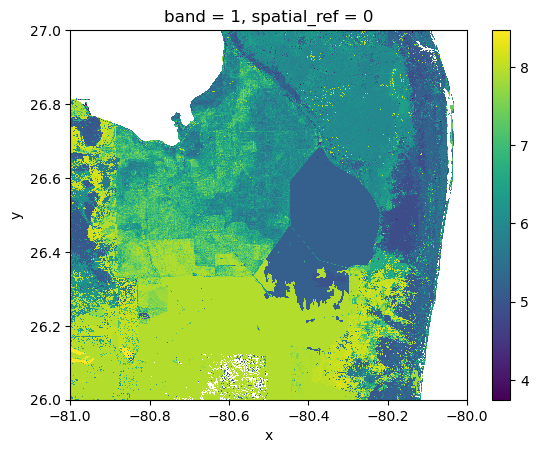

In [32]:
# mean pH values on right scale (~3-9 pH)
soil_da.plot()

#### Discussion


#### References

